# DeepFM

- 논문
  - DeepFM: A Factorization-Machine based Neural Network for CTR Prediction
- Tensorflow 구현 버전([링크](https://github.com/shenweichen/DeepCTR))
- PyTorch 버전([링크](https://github.com/shenweichen/DeepCTR-Torch))
- Factorization Machine 등 다양한 모델을 사용해 볼 수 있는 [torchfm 링크](https://pypi.org/project/torchfm/)
- Model architecture
- Click-through rate(CTR)을 예측하는 모델
- Factorization Machine과 Deep Learning 을 통합한 모델
- Wide & Deep 처럼 low-order featrue interaction과 high-order feature interaction 모두를 표현 가능함
- Wide & Deep 과 달리 FM 파트와 DL 파트가 같은 input을 공유하며 별도의 feature engineering이 필요없다는 장점이 있음

- 구조도

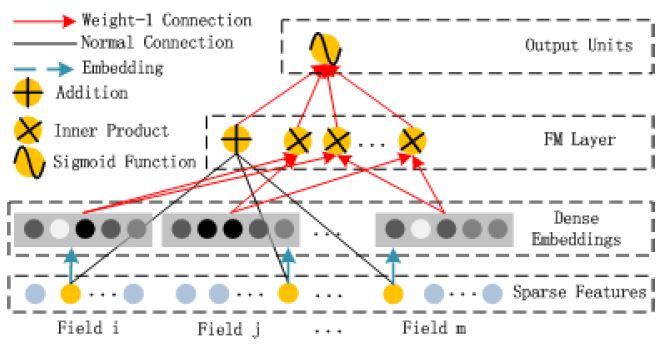

# Torchfm

In [4]:
!pip install torchfm

  Created wheel for torchfm: filename=torchfm-0.7.0-py3-none-any.whl size=18357 sha256=b0192923544c809ad84eb958938ff6fc5fdb519faea6f35b2c3776baaecea7dc
  Stored in directory: /root/.cache/pip/wheels/5e/e9/25/1ae407681ff67b4334513b7793ced4c66a4bf37ee99ed31ffe
Successfully built torchfm


In [5]:
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
import os
from torch.utils.data import DataLoader
import torch.utils.data
import tqdm

In [82]:
class FeaturesLinear(torch.nn.Module):

    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        # item index를 0부터 시작하는 것이 아니라, user 466에 이어 467부터 시작하도록 offset 설정
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long) 

    def forward(self, x):
        # |x| = (batch_size, num_of_fields)
        # x와 같은 shape로 offsets 생성 ex) [10, 30]의 경우, [10, 496]가 되도록 + [0, 466]를 하기 위함
        # x.shape는 offsets.shape와 같지 않아도 됨 x.new_tensor(data)의 형태로 적용할 경우, x의 dtype, device 정도를 복사함
        x = x + x.new_tensor(self.offsets).unsqueeze(0)

        return torch.sum(self.fc(x), dim=1) + self.bias


class FeaturesEmbedding(torch.nn.Module):

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        #xavier_uniform 참고 자료: https://eda-ai-lab.tistory.com/404
        torch.nn.init.xavier_uniform_(self.embedding.weight.data) 

    def forward(self, x):
        # |x| = (batch_size, num_fields)
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)


class FactorizationMachine(torch.nn.Module):

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x):
        # |x| = (batch_size, num_fields, embed_dim)

        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        
        # sum each fm result value
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix


class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, embed_dims, dropout, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(input_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, x):
        # |x| = (batch_size, embed_dim)
        return self.mlp(x)

In [83]:
class DeepFactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of DeepFM.

    Reference:
        H Guo, et al. DeepFM: A Factorization-Machine based Neural Network for CTR Prediction, 2017.
    """

    def __init__(self, field_dims, embed_dim, mlp_dims, dropout):
        super().__init__()
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout)

    def forward(self, x):
        # |x| = (batch_size, num_fields)
        embed_x = self.embedding(x)
        # |embed_x| = (batch_size, num_fields, embed_dim)

        # deep part: concat each embedding vector    
        x = self.linear(x) + self.fm(embed_x) + self.mlp(embed_x.view(-1, self.embed_output_dim))
        # |x| = (batch_size, 1)
        return torch.sigmoid(x.squeeze(1))

## Load dataset and Train model


In [84]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/data/kmrd/kmr_dataset/datafile/kmrd-small'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
class KMRDDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        data = pd.read_csv(os.path.join(data_path,'rates.csv'))[:10000]
        
        user_to_index = {original: idx for idx, original in enumerate(data.user.unique())}
        movie_to_index = {original: idx for idx, original in enumerate(data.movie.unique())}
        data['user'] = data['user'].apply(lambda x: user_to_index[x])
        data['movie'] = data['movie'].apply(lambda x: movie_to_index[x])
        # [user, movie, rate] -> (user, movie, rate)
        data = data.to_numpy()[:, :3]

        self.items = data[:, :2].astype(np.int)  # -1 because ID begins from 1
        self.targets = self.__preprocess_target(data[:, 2]).astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0,), dtype=np.long)
        self.item_field_idx = np.array((1,), dtype=np.long)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target[target <= 9] = 0
        target[target > 9] = 1
        return target

In [86]:
dataset = KMRDDataset(data_path=data_path)

In [87]:
print(dataset.item_field_idx)
print(dataset.field_dims)
print(sum(dataset.field_dims))
print(torch.nn.Embedding(sum(dataset.field_dims), 16))
print(torch.nn.Parameter(torch.zeros((1,))))
print(np.array((0, *np.cumsum(dataset.field_dims)[:-1]), dtype=np.long))

[1]
[466 532]
998
Embedding(998, 16)
Parameter containing:
tensor([0.], requires_grad=True)
[  0 466]


In [88]:
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    dataset, (train_length, valid_length, test_length))

In [89]:
train_data_loader = DataLoader(train_dataset, batch_size=16)
valid_data_loader = DataLoader(valid_dataset, batch_size=16)
test_data_loader = DataLoader(test_dataset, batch_size=1)

In [90]:
print(dataset.items)
print(dataset.targets)

[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [465  15]
 [465  15]
 [465 338]]
[0. 0. 0. ... 0. 0. 0.]


In [123]:
a = next(iter(train_data_loader))[0]
print(a.new_tensor([0,1,2,3,4]))

tensor([0, 1, 2, 3, 4])


In [91]:
model = DeepFactorizationMachineModel(dataset.field_dims, embed_dim=16, mlp_dims=(16, 16), dropout=0.2)
model

DeepFactorizationMachineModel(
  (linear): FeaturesLinear(
    (fc): Embedding(998, 1)
  )
  (fm): FactorizationMachine()
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(998, 16)
  )
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)

In [92]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-6)

In [93]:
log_interval = 100

model.train()
total_loss = 0
tk0 = tqdm.tqdm(train_data_loader, smoothing=0, mininterval=1.0)
for i, (fields, target) in enumerate(tk0):
    # |fields| = (batch_size, 2), |target| = (batch_size, 1) 
    # 2 of fields = [user_index, item_index], 1 of target = [rating]
    # fields, target = fields.to(device), target.to(device)
    y = model(fields)
    loss = criterion(y, target.float())
    model.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    if (i + 1) % log_interval == 0:
        tk0.set_postfix(loss=total_loss / log_interval)
        total_loss = 0

100%|██████████| 500/500 [00:01<00:00, 365.56it/s, loss=0.621]
